In [14]:
import json
import numpy as np
from PIL import Image
import cv2
import os

# Define class mapping (adjust based on your VIA attributes)
class_map = {
    "court": 0
}

# Paths
image_dir = "dataset/images/"
mask_dir = "dataset/masks/"
os.makedirs(mask_dir, exist_ok=True)
annotation_file = "via_annotations.json"


In [20]:
import json
import numpy as np
from PIL import Image
import cv2
import os

# Define class mapping
class_map = {
    "background": 0,
    "object": 1
}

# Paths
image_dir = "dataset/images/"
mask_dir = "dataset/masks/"
os.makedirs(mask_dir, exist_ok=True)
annotation_file = "via_annotations.json"

# Load JSON annotations
with open(annotation_file, 'r') as f:
    data = json.load(f)

# Process each image
for key, value in data.items():
    filename = value['filename']
    img_path = os.path.join(image_dir, filename)
    
    # Load image and get dimensions
    try:
        img = Image.open(img_path)
        width, height = img.size
        print(f"\nProcessing {filename}")
        print(f"Image dimensions: {width}x{height}")
    except FileNotFoundError:
        print(f"Image not found: {img_path}. Skipping.")
        continue
    
    # Create empty mask
    mask = np.zeros((height, width), dtype=np.uint8)
    
    # Process regions
    regions = value['regions']
    print(f"Number of regions: {len(regions)}")
    if not regions:
        print(f"No regions found for {filename}")
    
    for i, region in enumerate(regions):
        shape = region['shape_attributes']
        class_name = region['region_attributes'].get('class', 'object')
        class_id = class_map[class_name]
        print(f"Region {i}: Class = {class_name} (ID = {class_id})")
        
        if shape['name'] == 'polygon':
            x_coords = shape['all_points_x']
            y_coords = shape['all_points_y']
            print(f"Polygon X coords: {x_coords}")
            print(f"Polygon Y coords: {y_coords}")
            
            # Validate polygon
            if len(x_coords) < 3 or len(y_coords) < 3:
                print(f"Invalid polygon: too few points")
                continue
            if len(x_coords) != len(y_coords):
                print(f"Invalid polygon: X/Y length mismatch")
                continue
            
            # Check bounds
            max_x, min_x = max(x_coords), min(x_coords)
            max_y, min_y = max(y_coords), min(y_coords)
            print(f"Polygon bounds: X = [{min_x}, {max_x}], Y = [{min_y}, {max_y}]")
            if max_x >= width or max_y >= height or min_x < 0 or min_y < 0:
                print(f"Warning: Coordinates out of bounds")
            
            # Draw polygon
            coords = np.array(list(zip(x_coords, y_coords)), np.int32)
            print(f"Coords array shape: {coords.shape}")
            cv2.fillPoly(mask, [coords], class_id)
            print(f"Drew polygon with class ID {class_id}")
    
    # Save mask
    mask_path = os.path.join(mask_dir, filename.replace('.jpg', '_mask.png'))
    Image.fromarray(mask).save(mask_path)
    print(f"Saved mask: {mask_path}")
    
    # Check mask content
    mask_array = np.array(Image.open(mask_path))
    unique_values = np.unique(mask_array)
    print(f"Unique values in mask: {unique_values}")
    
    # Break after one image for debugging
    break

# Test OpenCV drawing
test_mask = np.zeros((500, 500), dtype=np.uint8)
test_coords = np.array([[10, 10], [100, 10], [100, 100]], np.int32)
cv2.fillPoly(test_mask, [test_coords], 1)
Image.fromarray(test_mask).save("test_mask.png")
print(f"Test mask unique values: {np.unique(np.array(Image.open('test_mask.png')))}")


Processing Video_250210220923_Slice_1_frame_0030_jpg.rf.76a47684a2613c61bc710cba7abe2c10.jpg
Image dimensions: 640x640
Number of regions: 1
Region 0: Class = object (ID = 1)
Polygon X coords: [130, 104, 97, 85, 61, 33, 17, 176, 399, 622, 601, 527, 507, 506, 491, 477, 470, 450, 434, 383, 322, 270, 215, 136]
Polygon Y coords: [300, 369, 394, 416, 478, 560, 602, 593, 581, 573, 514, 338, 289, 282, 280, 279, 279, 279, 278, 274, 275, 277, 284, 298]
Polygon bounds: X = [17, 622], Y = [274, 602]
Coords array shape: (24, 2)
Drew polygon with class ID 1
Saved mask: dataset/masks/Video_250210220923_Slice_1_frame_0030_jpg.rf.76a47684a2613c61bc710cba7abe2c10_mask.png
Unique values in mask: [0 1]
Test mask unique values: [0 1]


In [22]:
from PIL import Image
import numpy as np
mask = np.array(Image.open("dataset/masks/Video_250210220923_Slice_1_frame_0030_jpg.rf.76a47684a2613c61bc710cba7abe2c10_mask.png"))
print("Shape:", mask.shape)
print("Unique values:", np.unique(mask, return_counts=True))  # Counts of each value

Shape: (640, 640)
Unique values: (array([0, 1], dtype=uint8), array([260015, 149585]))


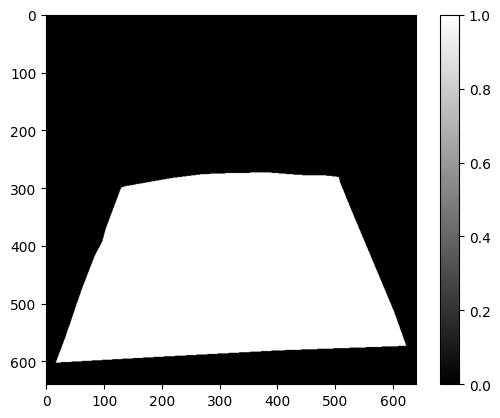

In [27]:
import matplotlib.pyplot as plt
plt.imshow(mask, cmap='gray')
plt.colorbar()
plt.show()